# Create training dataset & EDA
The goal is to:
- create grid points over spatial (0.5 mi) and time dimention (8 hours)
- then, associate each grid point with the number of crime incidents reported in the Boston Police Department Report

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import calendar
import time
import matplotlib.pyplot as plt
import math
import random

## (0) Define functions to be used later 

In [2]:
def what_hourgroup(hr):
    '''
    Define period of time in a day 
    '''
    if hr >= 0 and hr <=7:
        return 1
    if hr >= 8 and hr <=15:
        return 2
    if hr >= 16 and hr <=23:
        return 3

In [3]:
def clean_input_df(df):
    '''
    Clean the data from the police report.
    '''
    print (" initial data rows ", df.shape)
    # first drop entires without location
    long_null_is_true = df["Long"].isnull() == True
    long_is_minus_one = df["Long"]>-10
    ind_to_drop_no_loc = df[long_null_is_true | long_is_minus_one].index
    df_drop_nolac = df.drop(ind_to_drop_no_loc, axis=0)
    print ("   after drop no location ", df_drop_nolac.shape)
    
    # next drop duplicates entires 
    df_drop_nolac = df_drop_nolac[df_drop_nolac.duplicated(keep="first") == False]
    # check if there still be duplicates
    print ("   # of duplicated entry : " 
           + str(df_drop_nolac[df_drop_nolac.duplicated(keep=False)].shape[0]))
    print ("   after drop duplicated entry", df_drop_nolac.shape)
    
    # drop irrelevant crimes
    irr_crimes      = df_drop_nolac['OFFENSE_CODE_GROUP'] == "Motor Vehicle Accident Response"
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Towed")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Property Found")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Missing Person Located")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Gambling")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Medical Assistance")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Violations")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_DESCRIPTION'] == "VAL - VIOLATION OF AUTO LAW - OTHER")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Investigate Person")
    irr_crimes      = irr_crimes | (df_drop_nolac["OFFENSE_CODE_GROUP"].str.contains("License Plate"))
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Service")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "INVESTIGATE PERSON")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Investigate Property")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Fraud")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Warrant Arrests")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Confidence Games")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Police Service Incidents")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Fire Related Reports")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "License Violation")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Counterfeiting")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Landlord/Tenant Disputes")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Ballistics")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Search Warrants")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Auto Theft Recovery")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Recovered Stolen Property")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Firearm Discovery")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "License Plate Related Incidents")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Evading Fare")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Embezzlement")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Prisoner Related Incidents")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Harbor Related Incidents")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Aircraft")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Phone Call Complaints")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Restraining Order Violations")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Verbal Disputes")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Liquor Violation")
    irr_crimes      = irr_crimes | (df_drop_nolac['OFFENSE_CODE_GROUP'] == "Assembly or Gathering Violations")
    
    
    ind_to_drop_irr_crimes = df_drop_nolac[irr_crimes].index
    #print (ind_to_drop_irr_crimes)
    df_drop_nolac = df_drop_nolac.drop(ind_to_drop_irr_crimes, axis=0)
    print ("   after drop irrelevant crimes ", df_drop_nolac.shape)
    
    ## there still be duplicate incident but different in other columns
    ## df_drop_nolac[df_drop_nolac.duplicated(subset=["INCIDENT_NUMBER"],keep=False)]
    ## Since I am only interest in the occurence 
    ## so for the df used in prediction I should get rid of these duplicates.
    uniqueID_cond = df_drop_nolac.duplicated(subset=["INCIDENT_NUMBER"],keep="first") == False
    df_uniq_id = df_drop_nolac[uniqueID_cond]
    
    # sanity check
    print ("   # of duplicate incident id : " 
           + str(df_uniq_id.duplicated(subset=["INCIDENT_NUMBER"],keep=False).sum()))
    print ("   after drop duplicate incident id ", df_uniq_id.shape)

    # create new column for date and hour group
    df_uniq_id["DATE"] = df_uniq_id["OCCURRED_ON_DATE"].apply(lambda x: x.split(" ")[0])
    df_uniq_id["Hour_Grp"] = df_uniq_id["HOUR"].apply(lambda x: what_hourgroup(x))
    
    print (df_uniq_id.shape)
    return df_uniq_id
    

## (1) Read In Data

####  Read in the Shape File which defines Boston geographic extent

In [4]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

fp = "./data/raw/bos_land/bos_land.shp"
data_shapemap = gpd.read_file(fp)

# Convert data to global lat long
# EPSG 4326 = WGS84 = https://epsg.io/4326
data_shapemap_geo = data_shapemap.to_crs(epsg=4326) 
multi_polygon = list(data_shapemap_geo["geometry"][0])

def in_MutiPolygon(lat, lng, multi_polygon):
    is_inside = False
    for polg in multi_polygon:
        point = Point(lng, lat)
        is_inside = polg.contains(point)
        if is_inside:
            return is_inside
    return is_inside

#### Read in the Police Station Location File

In [5]:
## police station
df_policeStat = pd.read_csv("./data/raw/data_additional/Boston_Police_Stations.csv")

def get_shortest_dist_police(lat, lng, df_policeStat):
    min_dist = 1000
    for p in range(df_policeStat.shape[0]):
        pol_lng = df_policeStat["X"].iloc[p] 
        pol_lad = df_policeStat["Y"].iloc[p]
        
        y_dist = abs(pol_lad-lat) *(111/1.60934)
        x_dist = abs(pol_lng-lng) *(111/1.60934)
        dist = math.sqrt((y_dist**2) + (x_dist**2))
        if dist < min_dist:
            min_dist = dist
    return min_dist

In [6]:
df_policeStat.head(2)

,X,Y,OBJECTID,BLDG_ID,BID,ADDRESS,POINT_X,POINT_Y,NAME,NEIGHBORHOOD,CITY,ZIP,FT_SQFT,STORY_HT,PARCEL_ID
0,-71.124269,42.256482,1,Bos_1809107000_B0,100639,1249 Hyde Park Ave,757882.716120,2.918710e+06,District E-18 Police Station,Hyde Park,Boston,2136,8585.0,2.0,1809107000
1,-71.148368,42.286786,2,Bos_2005719000_B0,112112,1708 Centre St,751313.455964,2.929725e+06,District E-5 Police Station,West Roxbury,Boston,2132,7708.0,2.0,2005719000


#### Read in MBTA location Data

In [7]:
df_mbta = pd.read_csv("./data/raw/data_additional/MBTA_Rapid_Transit_Stops.csv")
# the same function  get_shortest_dist_police() can be used here

In [8]:
df_mbta.head(2)

,X,Y,OBJECTID,STATION,LINE,TERMINUS,ROUTE
0,-71.057171,42.342590,38,Broadway,RED,N,A - Ashmont B - Braintree C - Alewife
1,-71.056978,42.330122,39,Andrew,RED,N,A - Ashmont B - Braintree C - Alewife


#### Read in the Crime Incident data & Clean Data

In [9]:
df = pd.read_csv('./data/raw/crime_data/tmp16sv2e6q.csv')

In [10]:
df_uniq_id_crime = clean_input_df(df)
crime_df = df_uniq_id_crime.copy()

 initial data rows  (392580, 17)
   after drop no location  (367083, 17)
   # of duplicated entry : 0
   after drop duplicated entry (366428, 17)
   after drop irrelevant crimes  (172118, 17)
   # of duplicate incident id : 0
   after drop duplicate incident id  (153199, 17)


/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(153199, 19)


## (2) Initial EDA based on the data in the incident report

In [11]:
df_uniq_id_crime.head(2)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,DATE,Hour_Grp
2,I192042799,520,Residential Burglary,BURGLARY - RESIDENTIAL - FORCE,C11,358,NaN,2019-05-17 12:30:00,2019,5,Friday,12,Part One,CLAYBOURNE ST,42.296532,-71.071259,"(42.29653192, -71.07125916)",2019-05-17,2
3,I192042797,617,Larceny,LARCENY THEFT FROM BUILDING,D4,626,NaN,2019-06-06 20:13:00,2019,6,Thursday,20,Part One,QUEENSBERRY ST,42.342556,-71.098079,"(42.34255587, -71.09807867)",2019-06-06,3


In [12]:
df.head(2)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192042804,3108,Fire Related Reports,"FIRE REPORT - HOUSE, BUILDING, ETC.",C11,377,NaN,2019-06-06 21:20:00,2019,6,Thursday,21,Part Three,S MUNROE TER,42.292141,-71.052022,"(42.29214062, -71.05202240)"
1,I192042801,3115,Investigate Person,INVESTIGATE PERSON,C11,393,NaN,2019-06-06 21:17:00,2019,6,Thursday,21,Part Three,WRENTHAM ST,42.287906,-71.061998,"(42.28790635, -71.06199818)"


In [13]:
print ("dataset oldest date ", min(crime_df["DATE"]))
print ("dataset latest date ", max(crime_df["DATE"]))
_min = datetime.datetime(2015,6,15)
_max = datetime.datetime(2019,6,6)
print ("dataset total  days ", _max - _min)
print ("training ends 2018-03-31 (70%)" )
print ("validate ends 2018-10-31 (15%)" )

dataset oldest date  2015-06-15
dataset latest date  2019-06-06
dataset total  days  1452 days, 0:00:00
training ends 2018-03-31 (70%)
validate ends 2018-10-31 (15%)


#### Plot crime type (horzontal bars)

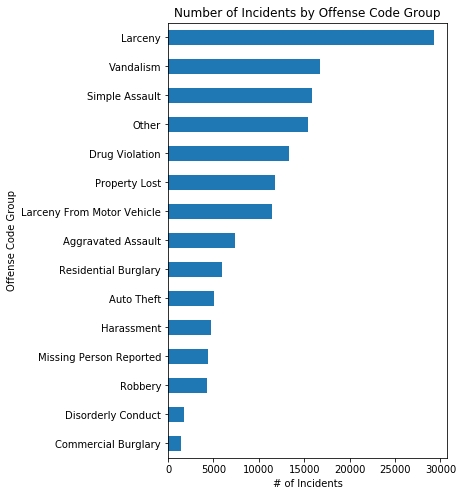

In [22]:
df_uniq_id_crime_pl = df_uniq_id_crime.groupby("OFFENSE_CODE_GROUP").count()
df_uniq_id_crime_pl = df_uniq_id_crime_pl.reset_index()
# sort before plotting
df_uniq_id_crime_pl = df_uniq_id_crime_pl.sort_values(by='INCIDENT_NUMBER', ascending=True) 

# plot only types that have counts > 1300
ax = df_uniq_id_crime_pl[df_uniq_id_crime_pl["INCIDENT_NUMBER"]>1300].plot(
                            kind='barh',x='OFFENSE_CODE_GROUP',
                            y='INCIDENT_NUMBER',
                            legend=False, figsize=(5, 8),
                            title="Number of Incidents by Offense Code Group"
                                                                     )
ax.set_ylabel("Offense Code Group")
ax.set_xlabel("# of Incidents")
plt.show()

#### Plot number of crimes in a day over the entire  dataset

In [23]:
df_train_date_pl = df_uniq_id_crime.groupby("DATE").count()
df_train_date_pl = df_train_date_pl.reset_index()
df_train_date_pl["DATE"].iloc[0]

'2015-06-15'

In [24]:
datetime_objects = []
for d_str in list(df_train_date_pl["DATE"]):
    datetime_object = datetime.datetime.strptime(d_str, '%Y-%m-%d')
    datetime_objects += [datetime_object]

In [26]:
# 10-day moving average 
average = df_train_date_pl["OFFENSE_CODE"].rolling(window=10).mean().iloc[10-1:].values

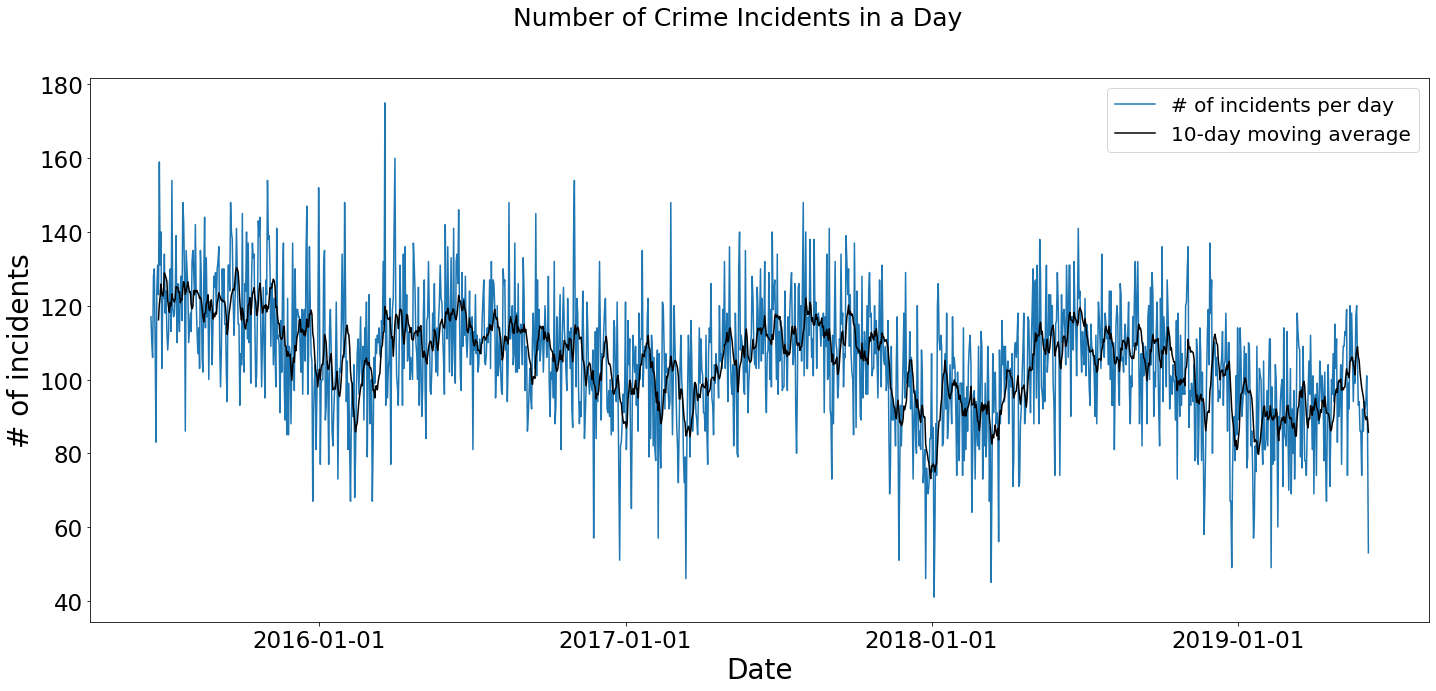

In [27]:
sns.set_style()
import matplotlib.dates as mdates

fig = plt.figure(figsize=(24,10))
ax = fig.add_subplot(111)
fig.suptitle('Number of Crime Incidents in a Day', fontsize=25)
plt.xlabel('Date', fontsize=28)
plt.ylabel('# of incidents', fontsize=28)
#plt.Axes.tick_params( axis='both',labelsize=18)
plt.tick_params(labelsize = 23)

locator = mdates.YearLocator()  # every month
fmt = mdates.DateFormatter('%Y-%m-%d') # Specify the format - %b gives us Jan, Feb...
ax.plot(datetime_objects,df_train_date_pl["OFFENSE_CODE"],label='# of incidents per day')
ax.plot(datetime_objects[9:],average,c='k',ls='-',label='10-day moving average')
ax.legend(prop={'size': 20})

#ax.tick_params(axis='both', which='major', labelsize=10)

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()

#### Plot number of total incidents in dataset as a function of hour in a day

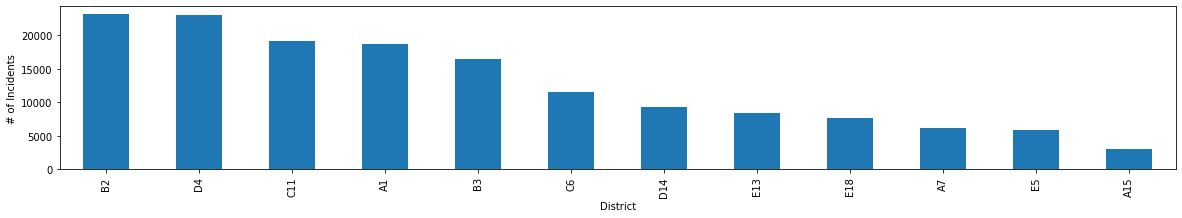

In [30]:
# plot 
df_uniq_id_crime_pl = df_uniq_id_crime.groupby("DISTRICT").count()
df_uniq_id_crime_pl = df_uniq_id_crime_pl.reset_index()
# sort before plotting
df_uniq_id_crime_pl = df_uniq_id_crime_pl.sort_values(by='INCIDENT_NUMBER', ascending=False) 
# df_uniq_id_crime_pl.head()
ax = df_uniq_id_crime_pl.plot(kind='bar',x='DISTRICT',y='INCIDENT_NUMBER', legend=False, figsize=(20, 3))
ax.set_ylabel("# of Incidents")
ax.set_xlabel("District")
plt.show()

#### Plot number of total incidents in dataset as a function of hour in a day

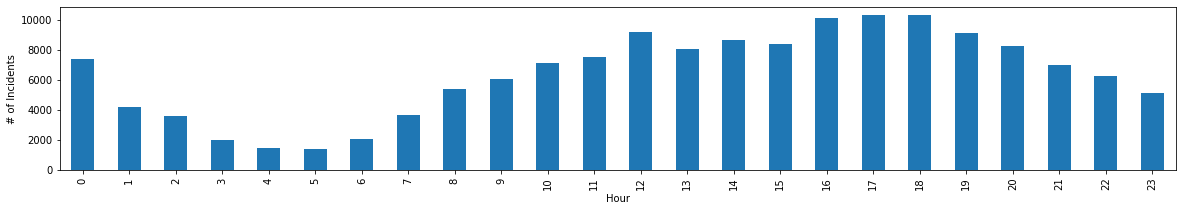

In [37]:
# plot 
df_uniq_id_crime_pl = df_uniq_id_crime.groupby("HOUR").count()
df_uniq_id_crime_pl = df_uniq_id_crime_pl.reset_index()
ax = df_uniq_id_crime_pl.plot(kind='bar',x='HOUR',y='INCIDENT_NUMBER', legend=False, figsize=(20, 3))
ax.set_ylabel("# of Incidents")
ax.set_xlabel("Hour")
plt.show()

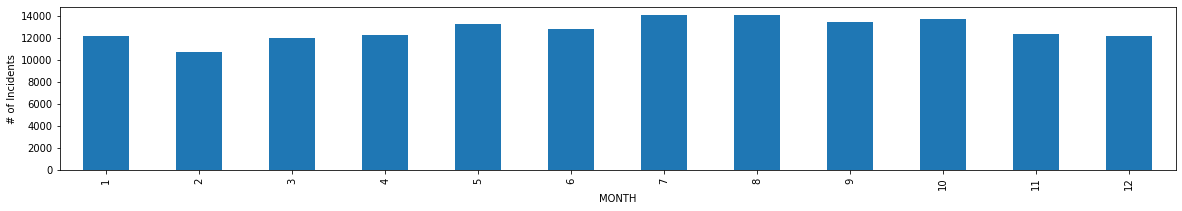

In [36]:
# plot 
df_uniq_id_crime_pl = df_uniq_id_crime.groupby("MONTH").count()
df_uniq_id_crime_pl = df_uniq_id_crime_pl.reset_index()
ax = df_uniq_id_crime_pl.plot(kind='bar',x='MONTH',y='INCIDENT_NUMBER', legend=False, figsize=(20, 3))
ax.set_ylabel("# of Incidents")
ax.set_xlabel("MONTH")
plt.show()

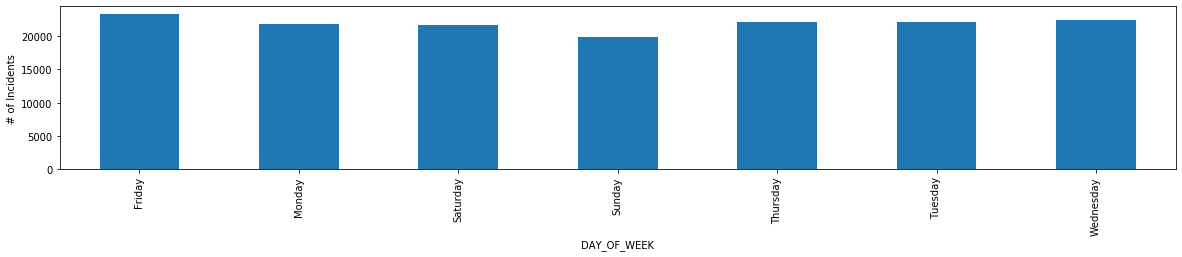

In [35]:
# plot 
df_uniq_id_crime_pl = df_uniq_id_crime.groupby("DAY_OF_WEEK").count()
df_uniq_id_crime_pl = df_uniq_id_crime_pl.reset_index()
ax = df_uniq_id_crime_pl.plot(kind='bar',x='DAY_OF_WEEK',y='INCIDENT_NUMBER', legend=False, figsize=(20, 3))
ax.set_ylabel("# of Incidents")
ax.set_xlabel("DAY_OF_WEEK")
plt.show()

## (3) Building the trainning and test data frame
#### Convert 1 mile to latitude and longitude
- latitude 111 km per degree
- 1 mile = 1.60934 km
- 1 mile => (1/111)*1.60934 = 0.0145 degree
- 0.5 mile => 0.00725 degree

#### What are the range of Lat and Long?
- Long -71.17867378, -70.96367615
- Lat 42.2324133, 42.39504158
- grid_deg = 0.0072

In [28]:
def get_latlng_list(lat_dn, lat_up, lng_dn, lng_up, grid_deg, do_rand):
    '''
    Function used to create grid points
    '''
    a = lat_dn
    lat_list=[]
    lat_list+=[a]
    
    b = lng_dn
    lng_list=[]
    lng_list+=[b]
    
    count = 0
    while a <= lat_up:
        b = lng_dn
        while b <= lng_up:
                
            if do_rand: 
                sf_lat = round((2*random.random())-1,4)
                sf_lng = round((2*random.random())-1,4)
            else:
                sf_lat = 1
                sf_lng = 1
                
            #print (a, b, sf_lat, sf_lng)
            a_sf = a + grid_deg*sf_lat
            b_sf = b + grid_deg*sf_lng
            
            lat_list += [round( a_sf ,4)] 
            lng_list += [round( b_sf ,4)]
            
            b+= grid_deg
            count+=1
        a+= grid_deg
        #print ("a ", a)
    print (count)
    return lat_list, lng_list

In [41]:
def isCrimeOccur_new3(inp_lat, inp_lng, grid_w, tmp_df): 
    '''
    Count the number of crime incidents for a given location
    within a specified radius
    '''
    #tmp_df["Lat"].iloc[0]
    #tmp_df["Lat"]
    dist = 0
    crime_occ = 0
    y_dist = 0
    x_dist = 0
    id_nums = []
    for i in range(tmp_df.shape[0]):
        la = tmp_df["Lat"].iloc[i]
        ln = tmp_df["Long"].iloc[i]
        id_num = tmp_df["INCIDENT_NUMBER"].iloc[i]
        y_dist = abs(inp_lat-la) *(111/1.60934)
        x_dist = abs(inp_lng-ln) *(111/1.60934)
        dist = math.sqrt((y_dist**2) + (x_dist**2))
        # radius considered now is = grid_w
        if dist < grid_w:
            crime_occ += 1
            id_nums += [id_num]
    return crime_occ, id_nums

### Run to Create Grid Points 

In [2]:
# parameters setup for segmenting the area
grid_w = 0.5 # mi
grid_deg = round((grid_w/111)*1.60934, 4)

lat_dn = 42.2324
lat_up = 42.3951
lng_dn = -71.1787
lng_up = -70.9636

# Set Dates to be processed
start_day = datetime.datetime(2018,4,1)
last_day = datetime.datetime(2018,10,31)

In [40]:
#lat_list, lng_list =  get_latlng_list(lat_dn, lat_up, lng_dn, lng_up, grid_deg, False)
lat_list, lng_list =  get_latlng_list(lat_dn, lat_up, lng_dn, lng_up, grid_deg, True)

##-----------------------------------------##
# dataset oldest date  2015-06-15
# dataset latest date  2019-06-06
# dataset total  days  1452 days, 0:00:00
# training ends 2018-03-31 (70%)
# validate ends 2018-10-31 (15%)
##-----------------------------------------##

d = start_day
dates = []
dates += [d]
#for i in range (10): 
while d < last_day: 
    d += datetime.timedelta(days=1)
    dates += [d]  

hour_groups = [1,2,3]

690


In [42]:
start_time = time.time()
data = []
cnt = 0
for i in range(len(lng_list)):
    lng = lng_list[i]  
    lat = lat_list[i] 
    cnt +=1 
    print ("count : ", cnt )
        
        
    dist_closest_police = get_shortest_dist_police(lat, lng, df_policeStat)
    dist_closest_mbta = get_shortest_dist_police(lat, lng, df_mbta)

    cond2 = crime_df["Lat"] < (lat + 1.1*grid_deg)
    cond3 = crime_df["Lat"] > (lat - 1.1*grid_deg)
    cond4 = crime_df["Long"] < (lng + 1.1*grid_deg)
    cond5 = crime_df["Long"] > (lng - 1.1*grid_deg)
    tmp_df_loc = crime_df[cond2 & cond3 & cond4 & cond5]

    in_Bos = in_MutiPolygon(lat, lng, multi_polygon)
    if in_Bos:
        for day in dates:
            #print (day)
            crime_df_single_date = tmp_df_loc[tmp_df_loc["DATE"] == str(day.date())]
            for this_hr in hour_groups:
                crime_df_single_date_time = crime_df_single_date[crime_df_single_date["Hour_Grp"] == this_hr]
                #print ("Hour_Grp ", this_hr)
                out_val = 0
                out_ids = []

                out_val, out_ids = isCrimeOccur_new3(lat,lng,grid_w,crime_df_single_date_time)
                dat = {'Lat': lat,'Long': lng, 
                       'DATE':day, 
                       'DAY_OF_WEEK':calendar.day_name[day.weekday()],
                       'MONTH':day.month,
                       'YEAR':day.year,
                       'DAY_OF_MONTH':day.day,
                       'Hour_Grp':this_hr,
                       'Value': out_val,
                       'INCIDENT_NUMBER': out_ids,
                       'closest_police_d': dist_closest_police,
                       'closest_mbta_d': dist_closest_mbta,
                      }
                data += [dat]
                    
fullTrainTest_DF = pd.DataFrame(data)
print ("Elapsed time: ", str(time.time()-start_time))
print (fullTrainTest_DF.shape) # (2838, 9)
print (fullTrainTest_DF["Value"].value_counts())

count :  1
count :  2
count :  3
count :  4
count :  5
count :  6
count :  7
count :  8
count :  9
count :  10
count :  11
count :  12
count :  13
count :  14
count :  15
count :  16
count :  17
count :  18
count :  19
count :  20
count :  21
count :  22
count :  23
count :  24
count :  25
count :  26
count :  27
count :  28
count :  29
count :  30
count :  31
count :  32
count :  33
count :  34
count :  35
count :  36
count :  37
count :  38
count :  39
count :  40
count :  41
count :  42
count :  43
count :  44
count :  45
count :  46
count :  47
count :  48
count :  49
count :  50
count :  51
count :  52
count :  53
count :  54
count :  55
count :  56
count :  57
count :  58
count :  59
count :  60
count :  61
count :  62
count :  63
count :  64
count :  65
count :  66
count :  67
count :  68
count :  69
count :  70
count :  71
count :  72
count :  73
count :  74
count :  75
count :  76
count :  77
count :  78
count :  79
count :  80
count :  81
count :  82
count :  83
count :  84
c

count :  648
count :  649
count :  650
count :  651
count :  652
count :  653
count :  654
count :  655
count :  656
count :  657
count :  658
count :  659
count :  660
count :  661
count :  662
count :  663
count :  664
count :  665
count :  666
count :  667
count :  668
count :  669
count :  670
count :  671
count :  672
count :  673
count :  674
count :  675
count :  676
count :  677
count :  678
count :  679
count :  680
count :  681
count :  682
count :  683
count :  684
count :  685
count :  686
count :  687
count :  688
count :  689
count :  690
count :  691
Elapsed time:  223.88376212120056
(164352, 12)
0     121670
1      27425
2       9477
3       3575
4       1351
5        532
6        206
7         84
8         14
9         11
11         4
10         2
12         1
Name: Value, dtype: int64


### Save output

In [49]:
fullTrainTest_DF.to_csv('./data/interim/crime_data/fullTrainTestCrimeData_valid_police_rand_2019_06_27.csv')

### Plot crime incidents on a map
- from raw data after cleaning

In [82]:
date_to_plot = "2019-06-01"
print (df_uniq_id_crime[df_uniq_id_crime["DATE"] == date_to_plot].shape)

import folium
boston_map_crime = folium.Map(location=[42.295, -71.057083],
                        zoom_start=11.3)
                         #     ,
                        #tiles="CartoDB dark_matter")

for i in range(df_uniq_id_crime.shape[0]):
    if df_uniq_id_crime["DATE"].iloc[i] ==  date_to_plot:
        lat = df_uniq_id_crime['Lat'].iloc[i]
        long = df_uniq_id_crime['Long'].iloc[i]
        radius = 3.5
        color = "#FF4500"

        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Criminal Incidents : {}<br>"""
        popup_text = popup_text.format(lat,
                                   long,
                                   df_uniq_id_crime['Lat'].iloc[i]
                                   )
        folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(boston_map_crime)

        
boston_map_crime.save('./reports/plot_data_BOS.html')

from IPython.display import IFrame
IFrame(src='./reports/plot_data_BOS.html', width=400, height=400)

(94, 19)
